# **Step 2: Pre-sceening and Dataset Construction**

### Using Subset of 2020 Data for noise injection

In [ ]:
import pandas as pd
df = pd.read_csv(r"/XXXX/ACL/CSVs/2020/Filtered_acl2020.csv",encoding="ISO-8859-1")

In [ ]:
import pandas as pd

# Select 50 distinct titles
distinct_titles = df['Title'].drop_duplicates().sample(n=50, random_state=42)

# Filter the dataset to include only rows that match the 50 distinct titles
fifty_df = df[df['Title'].isin(distinct_titles)]

print(fifty_df.head())


                                                 Title  \
127  More Diverse Dialogue Datasets via Diversity-I...   
128  More Diverse Dialogue Datasets via Diversity-I...   
129  More Diverse Dialogue Datasets via Diversity-I...   
130  More Diverse Dialogue Datasets via Diversity-I...   
131  More Diverse Dialogue Datasets via Diversity-I...   

                                              Abstract  \
127  Automated generation of conversational dialogu...   
128  Automated generation of conversational dialogu...   
129  Automated generation of conversational dialogu...   
130  Automated generation of conversational dialogu...   
131  Automated generation of conversational dialogu...   

                                             Paragraph  
127  Proceedings of the 58th Annual Meeting of the ...  
128  It is well-documented that neural dialogue mod...  
129  Improving model diversity is an important goal...  
130  Basu Roy et al. (2015) formulates the problem ...  
131  An additiona

### 50 Papers taken for noise injection

In [ ]:
folder_path = "/XXXX/ACL/CSVs/2020"

# Ensure the folder exists before saving
import os
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  # Create the folder if it doesn't exist

# Full path to save the CSV file
csv_path = os.path.join(folder_path, "Fifty_Papers.csv")

# Save DataFrame as CSV
fifty_df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")

In [ ]:
fifty_df['Title'].nunique()

50

In [ ]:
fifty_df.shape

(748, 3)

### Remaining data will be used for further evaluation in 2020

In [ ]:
remaining_df = df[~df['Title'].isin(distinct_titles)]

folder_path = "/XXXX/ACL/CSVs/2020"

# Ensure the folder exists before saving
import os
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  # Create the folder if it doesn't exist

csv_path = os.path.join(folder_path, "Test_data2020.csv")

remaining_df.to_csv(csv_path, index=False)

print(remaining_df.head())  # First few rows of remaining data

                                            Title  \
0  Neural Generation of Dialogue Response Timings   
1  Neural Generation of Dialogue Response Timings   
2  Neural Generation of Dialogue Response Timings   
3  Neural Generation of Dialogue Response Timings   
4  Neural Generation of Dialogue Response Timings   

                                            Abstract  \
0  The timings of spoken response offsets in huma...   
1  The timings of spoken response offsets in huma...   
2  The timings of spoken response offsets in huma...   
3  The timings of spoken response offsets in huma...   
4  The timings of spoken response offsets in huma...   

                                           Paragraph  
0  The components needed for the design of spoken...  
1  Dataset Our dataset is extracted from the Swit...  
2  Encoder The encoder of RTNet (shown in Fig. 3)...  
3  Motivation A limitation of RTNet is that it ma...  
4  Linguistic Features We use the word annotation...  


In [ ]:
remaining_df['Title'].nunique()

399

### Calculate Paragraph Coherence

In [ ]:
b_diff = pd.read_csv(r"/XXXX/ACL/CSVs/2020/Fifty_Papers.csv",encoding="ISO-8859-1")

In [ ]:
b_diff.shape

(748, 3)

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load the SBERT model
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(MODEL_NAME)

# Define the coherence scoring function
def get_coherence_scores(paragraph):

    # Define individual prompts for each criterion
    prompts = {
        "Contextual Consistency": "Does each sentence align with the preceding and following text?",
        "Logical Flow": "Does the paragraph follow a structured, logical progression?",
        "Relevance": "Do all sentences contribute meaningfully to the paragraph's main idea?"
    }

    scores = {}

    for criterion, prompt in prompts.items():
        # Generate a specific prompt for each category
        full_prompt = f"{prompt}\n\nParagraph:\n\"{paragraph}\"\n\nScore (0-1):"

        # Encode the prompt and paragraph
        embeddings = model.encode([full_prompt, paragraph], convert_to_tensor=True)

        # Compute cosine similarity score
        similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()

        # Normalize score to range (0-1)
        final_score = max(0, min(1, similarity_score))

        # Store score
        scores[criterion] = round(final_score, 4)

    return scores

def weighted_coherence(scores, weights={"Contextual Consistency": 0.3, "Logical Flow": 0.4, "Relevance": 0.3}):
    return round(sum(scores[key] * weights[key] for key in scores), 4)


# Define a function to apply the scoring to each paragraph
def apply_coherence_scores(b_diff):
    # Initialize lists to store the results
    contextual_consistency = []
    logical_flow = []
    relevance = []
    overall_coherence = []

    # Loop through each paragraph in the dataframe
    for index, row in b_diff.iterrows():
        paragraph = row['Paragraph']

        # Get coherence scores for the paragraph
        scores = get_coherence_scores(paragraph)
        overall_score = weighted_coherence(scores)

        # Append results to lists
        contextual_consistency.append(scores["Contextual Consistency"])
        logical_flow.append(scores["Logical Flow"])
        relevance.append(scores["Relevance"])
        overall_coherence.append(overall_score)

    # Add the scores to the dataframe as new columns
    b_diff['Contextual Consistency'] = contextual_consistency
    b_diff['Logical Flow'] = logical_flow
    b_diff['Relevance'] = relevance
    b_diff['Overall Coherence'] = overall_coherence

    return b_diff

# Apply the coherence scoring to the DataFrame
df_with_scores = apply_coherence_scores(b_diff)

In [ ]:
df_with_scores

,Title,Abstract,Paragraph,Contextual Consistency,Logical Flow,Relevance,Overall Coherence
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,0.4959,0.5040,0.5832,0.5253
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,It is well-documented that neural dialogue mod...,0.7393,0.7009,0.8352,0.7527
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,0.5930,0.5937,0.7137,0.6295
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. (2015) formulates the problem ...,0.3683,0.4315,0.3818,0.3976
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,0.3384,0.3578,0.3846,0.3600
...,...,...,...,...,...,...,...
743,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Humour baseline (Khandelwal et al., 2018): Use...",0.7169,0.6656,0.7145,0.6957
744,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,In order to draw the benefits of the modern de...,0.6784,0.6173,0.7308,0.6697
745,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Train-test split: For all datasets, we maintai...",0.4980,0.5743,0.5330,0.5390
746,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,We compare the baseline models along with (i) ...,0.4678,0.4444,0.5726,0.4899


### Calculate Abstract-Paragraph Relevance

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(MODEL_NAME)

# Function to calculate relevance scores between abstract and paragraph
def get_abstract_paragraph_coherence_scores(abstract, paragraph):


    prompts = {
        "Contextual Alignment": "Does the paragraph align with the main message of the abstract?",
        "Topical Relevance": "Is the paragraph content relevant to the research focus described in the abstract?",
        "Purpose Fit": "Does the paragraph support or expand on the purpose defined in the abstract?"
    }

    scores = {}

    for criterion, prompt in prompts.items():
        full_prompt = f"{prompt}\n\nAbstract:\n\"{abstract}\"\n\nParagraph:\n\"{paragraph}\"\n\nScore (0-1):"

        embeddings = model.encode([full_prompt, paragraph], convert_to_tensor=True)

        similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()

        scores[criterion] = round(max(0, min(1, similarity_score)), 4)

    return scores

def weighted_ap_coherence(scores, weights={"Contextual Alignment": 0.4, "Topical Relevance": 0.3, "Purpose Fit": 0.3}):
    return round(sum(scores[key] * weights[key] for key in scores), 4)

def apply_abstract_paragraph_coherence(df_with_scores):
    alignment_scores = []
    topical_scores = []
    purpose_scores = []
    overall_scores = []

    for _, row in df_with_scores.iterrows():
        abstract = row['Abstract']
        paragraph = row['Paragraph']

        scores = get_abstract_paragraph_coherence_scores(abstract, paragraph)
        overall = weighted_ap_coherence(scores)

        alignment_scores.append(scores["Contextual Alignment"])
        topical_scores.append(scores["Topical Relevance"])
        purpose_scores.append(scores["Purpose Fit"])
        overall_scores.append(overall)

    df_with_scores['#Contextual Alignment'] = alignment_scores
    df_with_scores['#Topical Relevance'] = topical_scores
    df_with_scores['#Purpose Fit'] = purpose_scores
    df_with_scores['Abstract-Paragraph Coherence'] = overall_scores

    return df_with_scores

df_with_scores = apply_abstract_paragraph_coherence(b_diff)

In [ ]:
df_with_scores.columns

Index(['Title', 'Abstract', 'Paragraph', 'Contextual Consistency',
       'Logical Flow', 'Relevance', 'Overall Coherence',
       '#Contextual Alignment', '#Topical Relevance', '#Purpose Fit',
       'Abstract-Paragraph Coherence'],
      dtype='object')

In [ ]:
df_with_scores['Abstract-Paragraph Coherence']

0      0.5753
1      0.6880
2      0.6643
3      0.4181
4      0.4677
        ...  
743    0.6828
744    0.7020
745    0.5788
746    0.5076
747    0.4088
Name: Abstract-Paragraph Coherence, Length: 748, dtype: float64

In [ ]:
# For example, if your coherence column is 'Overall Coherence'
print(df_with_scores['Overall Coherence'].describe())
print(df_with_scores['Abstract-Paragraph Coherence'].describe())

count    748.000000
mean       0.637866
std        0.114851
min        0.143600
25%        0.571475
50%        0.653000
75%        0.718900
max        0.919700
Name: Overall Coherence, dtype: float64
count    748.000000
mean       0.652803
std        0.117948
min        0.016100
25%        0.604850
50%        0.671200
75%        0.726425
max        0.857500
Name: Abstract-Paragraph Coherence, dtype: float64


In [ ]:
coherence_threshold = df_with_scores['Overall Coherence'].quantile(0.6)
relevance_threshold = df_with_scores['Abstract-Paragraph Coherence'].quantile(0.6)


In [ ]:
coherence_threshold

0.67864

In [ ]:
relevance_threshold

0.6925

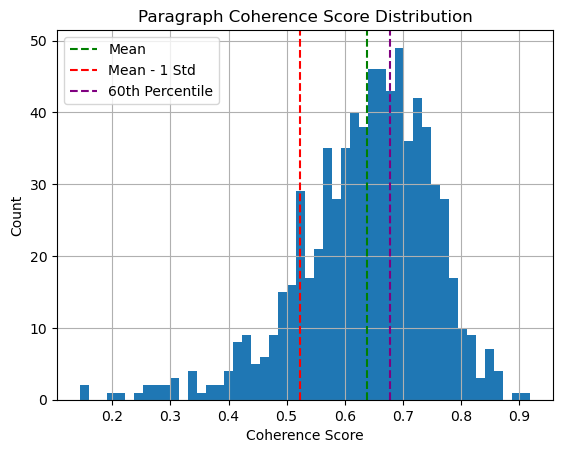

In [ ]:
import matplotlib.pyplot as plt

df_with_scores['Overall Coherence'].hist(bins=50)
plt.axvline(df_with_scores['Overall Coherence'].mean(), color='green', linestyle='--', label='Mean')
plt.axvline(df_with_scores['Overall Coherence'].mean() - df_with_scores['Overall Coherence'].std(), color='red', linestyle='--', label='Mean - 1 Std')
plt.axvline(df_with_scores['Overall Coherence'].quantile(0.6), color='purple', linestyle='--', label='60th Percentile')
plt.legend()
plt.title("Paragraph Coherence Score Distribution")
plt.xlabel("Coherence Score")
plt.ylabel("Count")
plt.show()


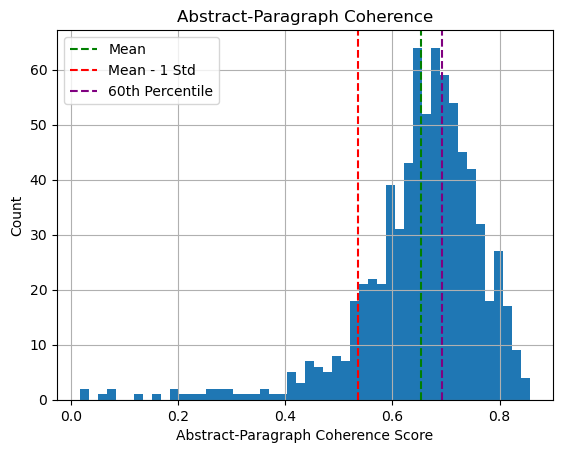

In [ ]:
import matplotlib.pyplot as plt

df_with_scores['Abstract-Paragraph Coherence'].hist(bins=50)
plt.axvline(df_with_scores['Abstract-Paragraph Coherence'].mean(), color='green', linestyle='--', label='Mean')
plt.axvline(df_with_scores['Abstract-Paragraph Coherence'].mean() - df_with_scores['Abstract-Paragraph Coherence'].std(), color='red', linestyle='--', label='Mean - 1 Std')
plt.axvline(df_with_scores['Abstract-Paragraph Coherence'].quantile(0.6), color='purple', linestyle='--', label='60th Percentile')
plt.legend()
plt.title("Abstract-Paragraph Coherence")
plt.xlabel("Abstract-Paragraph Coherence Score")
plt.ylabel("Count")
plt.show()


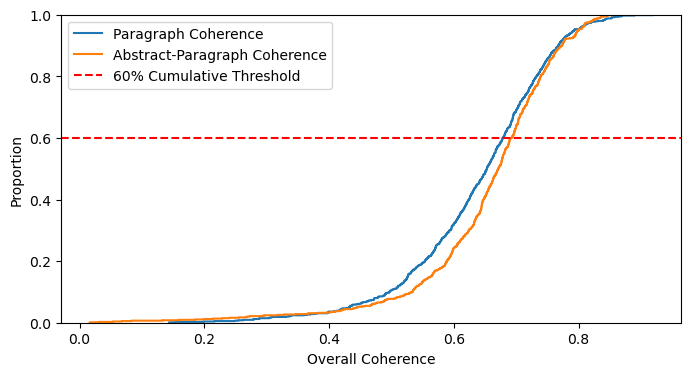

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.ecdfplot(data=df_with_scores, x="Overall Coherence", label='Paragraph Coherence')
sns.ecdfplot(data=df_with_scores, x="Abstract-Paragraph Coherence", label="Abstract-Paragraph Coherence")
plt.axhline(y=0.6, color='red', linestyle='--', label="60% Cumulative Threshold")
plt.legend()

In [ ]:
df_with_scores = df_with_scores[['Title','Abstract','Paragraph','Overall Coherence','Abstract-Paragraph Coherence']]

In [ ]:
df_with_scores

,Title,Abstract,Paragraph,Overall Coherence,Abstract-Paragraph Coherence
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,0.5253,0.5753
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,It is well-documented that neural dialogue mod...,0.7527,0.6880
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,0.6295,0.6643
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. (2015) formulates the problem ...,0.3976,0.4181
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,0.3600,0.4677
...,...,...,...,...,...
743,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Humour baseline (Khandelwal et al., 2018): Use...",0.6957,0.6828
744,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,In order to draw the benefits of the modern de...,0.6697,0.7020
745,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Train-test split: For all datasets, we maintai...",0.5390,0.5788
746,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,We compare the baseline models along with (i) ...,0.4899,0.5076


In [ ]:
df_with_scores.to_csv("Fifty_papers_with_scores.csv")

In [ ]:
import numpy as np

df_with_scores.loc[:, 'Temporay_Label'] = np.where(
    (df_with_scores['Overall Coherence'] > coherence_threshold) &
    (df_with_scores['Abstract-Paragraph Coherence'] > relevance_threshold),
    'positive',
    'negative'
)



In [ ]:
df_with_scores

,Title,Abstract,Paragraph,Overall Coherence,Abstract-Paragraph Coherence,Temporay_Label
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,0.5253,0.5753,negative
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,It is well-documented that neural dialogue mod...,0.7527,0.6880,negative
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,0.6295,0.6643,negative
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. (2015) formulates the problem ...,0.3976,0.4181,negative
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,0.3600,0.4677,negative
...,...,...,...,...,...,...
743,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Humour baseline (Khandelwal et al., 2018): Use...",0.6957,0.6828,negative
744,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,In order to draw the benefits of the modern de...,0.6697,0.7020,negative
745,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,"Train-test split: For all datasets, we maintai...",0.5390,0.5788,negative
746,Code-Switching Patterns Can Be an Effective Ro...,In this paper we demonstrate how codeswitching...,We compare the baseline models along with (i) ...,0.4899,0.5076,negative


In [ ]:
df_with_scores = df_with_scores.copy()

In [ ]:
df_positive_samples = df_with_scores[df_with_scores['Temporay_Label'] == 'positive'] ## Consistent

df_negative_samples = df_with_scores[df_with_scores['Temporay_Label'] == 'negative'] ##Inconsistent

In [ ]:
df_positive_samples.shape

(175, 6)

In [ ]:
df_negative_samples.shape

(573, 6)

### Down Sampling Inconsistent Samples

In [ ]:
subsetdf_negative_samples = df_negative_samples.head(275)

In [ ]:
subsetdf_negative_samples

,Title,Abstract,Paragraph,Overall Coherence,Abstract-Paragraph Coherence,Temporay_Label
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,0.5253,0.5753,negative
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,It is well-documented that neural dialogue mod...,0.7527,0.6880,negative
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,0.6295,0.6643,negative
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. (2015) formulates the problem ...,0.3976,0.4181,negative
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,0.3600,0.4677,negative
...,...,...,...,...,...,...
348,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,The model and training set-up is based on Merk...,0.5677,0.5872,negative
349,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,Trained models are evaluated by ranking all SB...,0.7856,0.6824,negative
350,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,Learnability is not just about eventual attain...,0.6681,0.6972,negative
351,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,We find indications that learning to extract m...,0.7434,0.6870,negative


In [ ]:
df_positive_samples.to_csv("Positive_Samples.csv")

In [ ]:
subsetdf_negative_samples.to_csv("Temp_Negative_Samples.csv")

## Noise Injection Using Mistral

In [ ]:
from huggingface_hub import login
login(token="XXXX")

In [ ]:
import pandas as pd
import torch
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.tokenize import sent_tokenize

df = pd.read_csv("Temp_Negative_Samples.csv")

# Initialize model and tokenizer
model_name = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)
model.eval()

def generate_noise_sentences(abstract, paragraph, num_sentences=3, max_new_tokens=300):
    prompt = f"""<s>[INST]
    Generate exactly {num_sentences} short sentences that are COMPLETELY UNRELATED to this abstract.
    The sentences should be obviously irrelevant and not contain any terms from the abstract.
    The irrelevant sentences should be related to Computer Science Domain. The generated sentences should break the paragraph coherence and logical flow of the paragraph.

    ### ABSTRACT:
    {abstract}

    ### IRRELEVANT SENTENCES:
    [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    noise = generated.split("### IRRELEVANT SENTENCES:")[-1].strip()
    x = sent_tokenize(noise)
    filtered = [s for s in x if not s.strip().replace('.','').isdigit()]
    return filtered
    #return [s.strip() for s in noise.split('.') if s.strip()][:num_sentences]

def inject_noise_random(abstract, paragraph, num_noise=3):
    try:
        noise_sentences = generate_noise_sentences(abstract, paragraph, num_sentences=num_noise)
        original_sentences = [s.strip() for s in paragraph.split('. ') if s.strip()]
        for noise in noise_sentences:
            insert_pos = random.randint(0, len(original_sentences))
            original_sentences.insert(insert_pos, noise)
        modified_paragraph = '. '.join(original_sentences)
        if not modified_paragraph.endswith('.'):
            modified_paragraph += '.'
        return modified_paragraph
    except Exception as e:
        print("Error injecting noise:", e)
        return paragraph

# Apply noise injection and log issues
def process_row(row):
    modified = inject_noise_random(row['Abstract'], row['Paragraph'])
    if modified.strip() == row['Paragraph'].strip():
        print("\n--- NO CHANGE ---")
        print("Abstract:", row['Abstract'][:100])
        print("Paragraph:", row['Paragraph'][:100])
    return modified

df['modified_paragraph'] = df.apply(process_row, axis=1)

# Check how many actually changed
num_changed = (df['modified_paragraph'] != df['Paragraph']).sum()
print(f"\nModified {num_changed} out of {len(df)} rows.")

# Optional: Save to CSV
df.to_csv("noisetest.csv", index=False)


## Make Finetune Dataset

In [ ]:
pos = pd.read_csv(r"/XXXX/ACL/CSVs/FinetuneDataset/Positive_Samples.csv",encoding="ISO-8859-1")
neg = pd.read_csv(r"/XXXX/ACL/CSVs/FinetuneDataset/noisetest.csv",encoding="ISO-8859-1")

In [ ]:
pos=pos[['Title','Abstract','Paragraph','Temporay_Label']]

In [ ]:
pos.head(5)

,Title,Abstract,Paragraph,Temporay_Label
0,"On Exposure Bias, Hallucination and Domain Shi...",The standard training algorithm in neural mach...,"Figure 1 shows that with MLE, distractor sente...",positive
1,Generative Semantic Hashing Enhanced via Boltz...,Generative semantic hashing is a promising tec...,An alternative way is to approximate the expec...,positive
2,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,Relation extraction aims to detect relations a...,positive
3,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,We construct three types of nodes for a docume...,positive
4,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,Unlike existing models that use co-reference l...,positive


In [ ]:
neg.head(5)

,Unnamed: 0,Title,Abstract,Paragraph,Overall Coherence,Abstract-Paragraph Coherence,Temporay_Label,modified_paragraph
0,0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,0.5253,0.5753,negative,Proceedings of the 58th Annual Meeting of the ...
1,1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,It is well-documented that neural dialogue mod...,0.7527,0.6880,negative,The rise of quantum computing has opened up ne...
2,2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,0.6295,0.6643,negative,Improving model diversity is an important goal...
3,3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. (2015) formulates the problem ...,0.3976,0.4181,negative,Basu Roy et al. Algorithmic complexity in grap...
4,4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,0.3600,0.4677,negative,An additional area related to our work is crow...


In [ ]:
neg=neg[['Title','Abstract','modified_paragraph','Temporay_Label']]

In [ ]:
neg

,Title,Abstract,modified_paragraph,Temporay_Label
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,negative
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,The rise of quantum computing has opened up ne...,negative
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,negative
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. Algorithmic complexity in grap...,negative
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,negative
...,...,...,...,...
270,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,The model and training set-up is based on Merk...,negative
271,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,The development of quantum computing has the p...,negative
272,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,The use of genetic algorithms in optimizing so...,negative
273,Learning to Understand Child-directed and Adul...,Speech directed to children differs from adult...,"A new algorithm for data compression, based on...",negative


In [ ]:
pos = pos.rename(columns={
    'Temporay_Label': 'Label',
})

In [ ]:
pos.head(5)

,Title,Abstract,Paragraph,Label
0,"On Exposure Bias, Hallucination and Domain Shi...",The standard training algorithm in neural mach...,"Figure 1 shows that with MLE, distractor sente...",positive
1,Generative Semantic Hashing Enhanced via Boltz...,Generative semantic hashing is a promising tec...,An alternative way is to approximate the expec...,positive
2,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,Relation extraction aims to detect relations a...,positive
3,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,We construct three types of nodes for a docume...,positive
4,Reasoning with Latent Structure Refinement for...,Document-level relation extraction requires in...,Unlike existing models that use co-reference l...,positive


In [ ]:
neg = neg.rename(columns={
    'modified_paragraph':'Paragraph',
    'Temporay_Label': 'Label'
})

In [ ]:
neg.head(5)

,Title,Abstract,Paragraph,Label
0,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Proceedings of the 58th Annual Meeting of the ...,negative
1,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,The rise of quantum computing has opened up ne...,negative
2,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Improving model diversity is an important goal...,negative
3,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,Basu Roy et al. Algorithmic complexity in grap...,negative
4,More Diverse Dialogue Datasets via Diversity-I...,Automated generation of conversational dialogu...,An additional area related to our work is crow...,negative


In [ ]:
result = pd.concat([pos, neg], ignore_index=True)

In [ ]:
result.shape

(450, 4)

In [ ]:
result.to_csv("Final_for_finetune.csv")